***DECISION TREE***

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/cleaned_variant_data_final.csv'
df = pd.read_csv(file_path, dtype={'Chromosome': str}, low_memory=False)
print(df.dtypes)

Mounted at /content/drive
Type                               object
Name                               object
GeneSymbol                         object
Origin                             object
Chromosome                         object
Start                               int64
ReviewStatus                       object
NumberSubmitters                    int64
Grouped_ClinicalSignificance       object
ReviewConfidence                  float64
is_frameshift                       int64
is_splice_site                      int64
is_missense                         int64
is_nonsense                         int64
is_synonymous                       int64
is_repeat_variant                   int64
type_Complex                         bool
type_Deletion                        bool
type_Duplication                     bool
type_Indel                           bool
type_Insertion                       bool
type_Inversion                       bool
type_Microsatellite                  bool
type_Tan

In [ ]:
df['Grouped_ClinicalSignificance'].value_counts()

,count
Grouped_ClinicalSignificance,
Uncertain significance,3226918
Likely benign,1738813
Benign,498134
Pathogenic,302815
Conflicting classification of pathogenicity,271029
Likely pathogenic,244478
Risk allele,46


In [ ]:
df = df[df['Grouped_ClinicalSignificance'] != 'Risk allele']

In [ ]:
# Separate features and target
X = df.drop('Grouped_ClinicalSignificance', axis=1)
y = df['Grouped_ClinicalSignificance']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Automatically detect and encode all object-type (categorical) columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Ensure conversion to string before encoding
    label_encoders[col] = le

# Encode the target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
class_names = le_target.classes_


In [ ]:
# Split the data with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [ ]:
# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

In [ ]:
# Measure training time
print("Training Decision Tree model...")
start_training_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_training_time
print(f"Training time: {training_time:.4f} seconds")


Training Decision Tree model...
Training time: 77.4479 seconds


In [ ]:
# Measure inference time
print("Making predictions...")
start_inference_time = time.time()
y_pred = dt_model.predict(X_test)
inference_time = time.time() - start_inference_time
print(f"Inference time: {inference_time:.4f} seconds")
print(f"Inference time per sample: {inference_time/len(y_test):.8f} seconds")

Making predictions...
Inference time: 1.0853 seconds
Inference time per sample: 0.00000086 seconds


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Overall Metrics:
Accuracy: 0.8794
Precision: 0.8338
Recall: 0.8209
F1 Score: 0.8271


In [ ]:
# Get detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))



Detailed Classification Report:
                                             precision    recall  f1-score   support

                                     Benign       0.75      0.72      0.74     99627
Conflicting classification of pathogenicity       1.00      1.00      1.00     54206
                              Likely benign       0.86      0.86      0.86    347763
                          Likely pathogenic       0.66      0.61      0.63     48895
                                 Pathogenic       0.81      0.81      0.81     60563
                     Uncertain significance       0.92      0.93      0.93    645384

                                   accuracy                           0.88   1256438
                                  macro avg       0.83      0.82      0.83   1256438
                               weighted avg       0.88      0.88      0.88   1256438



In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[ 71452      0  17402   1069    496   9208]
 [     0  54206      0      0      0      0]
 [ 14490      0 299731   2338    831  30373]
 [  1232      0   3677  29752   6544   7690]
 [   540      0   1258   5819  48855   4091]
 [  6964      0  27843   6023   3648 600906]]


In [ ]:
# Calculate TP, FP, TN, FN for each class
n_classes = len(class_names)
tp = np.zeros(n_classes)
fp = np.zeros(n_classes)
tn = np.zeros(n_classes)
fn = np.zeros(n_classes)

for i in range(n_classes):
    # True Positives
    tp[i] = cm[i, i]

    # False Positives (sum of column i excluding true positive)
    fp[i] = np.sum(cm[:, i]) - tp[i]

    # False Negatives (sum of row i excluding true positive)
    fn[i] = np.sum(cm[i, :]) - tp[i]

    # True Negatives (sum of all elements excluding elements in row i and column i, plus true positive)
    tn[i] = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])

# Print TP, FP, TN, FN for each class
print("\nPer-class Performance Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"  TP: {tp[i]:.0f}")
    print(f"  FP: {fp[i]:.0f}")
    print(f"  TN: {tn[i]:.0f}")
    print(f"  FN: {fn[i]:.0f}")
    print(f"  Precision: {tp[i] / (tp[i] + fp[i]):.4f}")
    print(f"  Recall: {tp[i] / (tp[i] + fn[i]):.4f}")
    print(f"  F1 Score: {2 * tp[i] / (2 * tp[i] + fp[i] + fn[i]):.4f}")


Per-class Performance Metrics:

Class: Benign
  TP: 71452
  FP: 23226
  TN: 1133585
  FN: 28175
  Precision: 0.7547
  Recall: 0.7172
  F1 Score: 0.7355

Class: Conflicting classification of pathogenicity
  TP: 54206
  FP: 0
  TN: 1202232
  FN: 0
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000

Class: Likely benign
  TP: 299731
  FP: 50180
  TN: 858495
  FN: 48032
  Precision: 0.8566
  Recall: 0.8619
  F1 Score: 0.8592

Class: Likely pathogenic
  TP: 29752
  FP: 15249
  TN: 1192294
  FN: 19143
  Precision: 0.6611
  Recall: 0.6085
  F1 Score: 0.6337

Class: Pathogenic
  TP: 48855
  FP: 11519
  TN: 1184356
  FN: 11708
  Precision: 0.8092
  Recall: 0.8067
  F1 Score: 0.8079

Class: Uncertain significance
  TP: 600906
  FP: 51362
  TN: 559692
  FN: 44478
  Precision: 0.9213
  Recall: 0.9311
  F1 Score: 0.9261


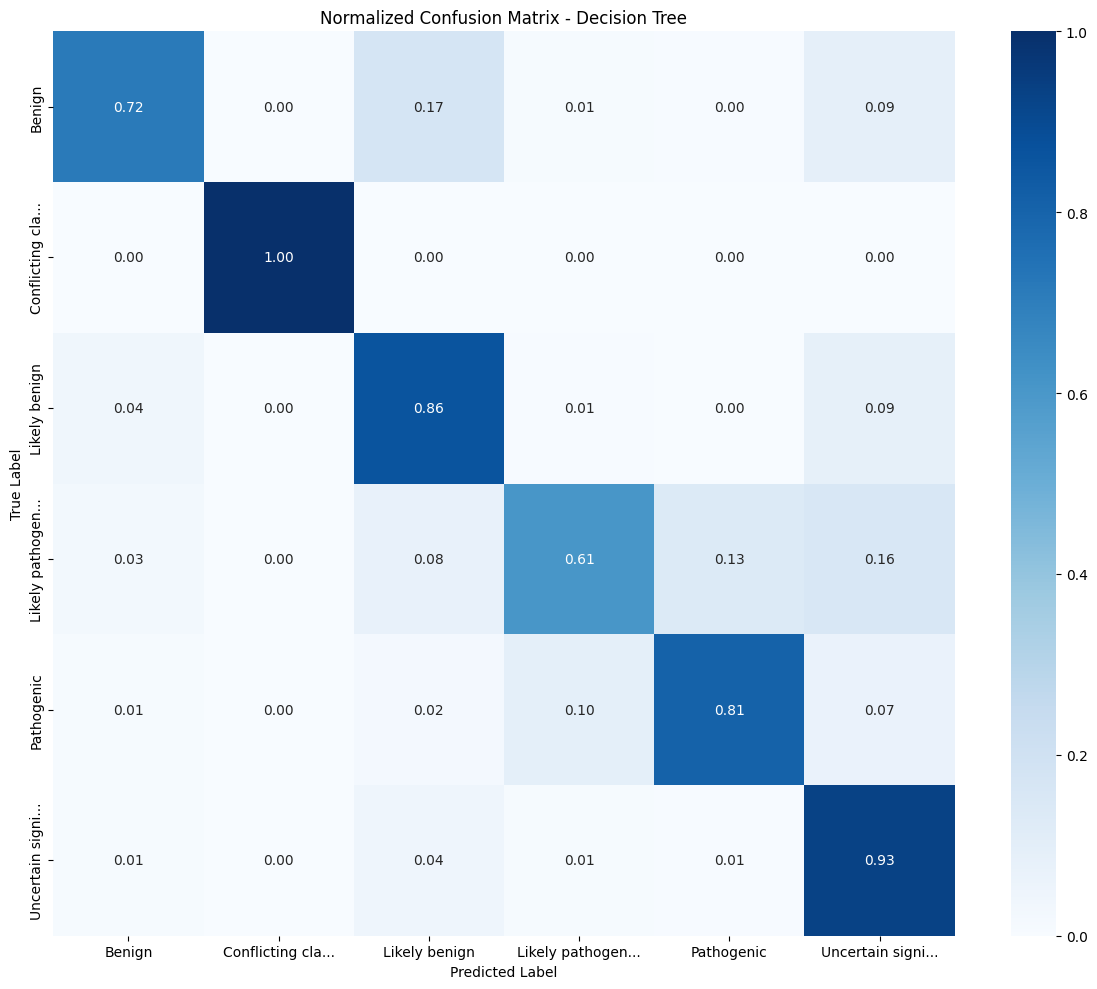

In [ ]:
# Normalize confusion matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[name[:15] + '...' if len(name) > 15 else name for name in class_names],
            yticklabels=[name[:15] + '...' if len(name) > 15 else name for name in class_names])
plt.title('Normalized Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('decision_tree_confusion_matrix.png')
plt.show()

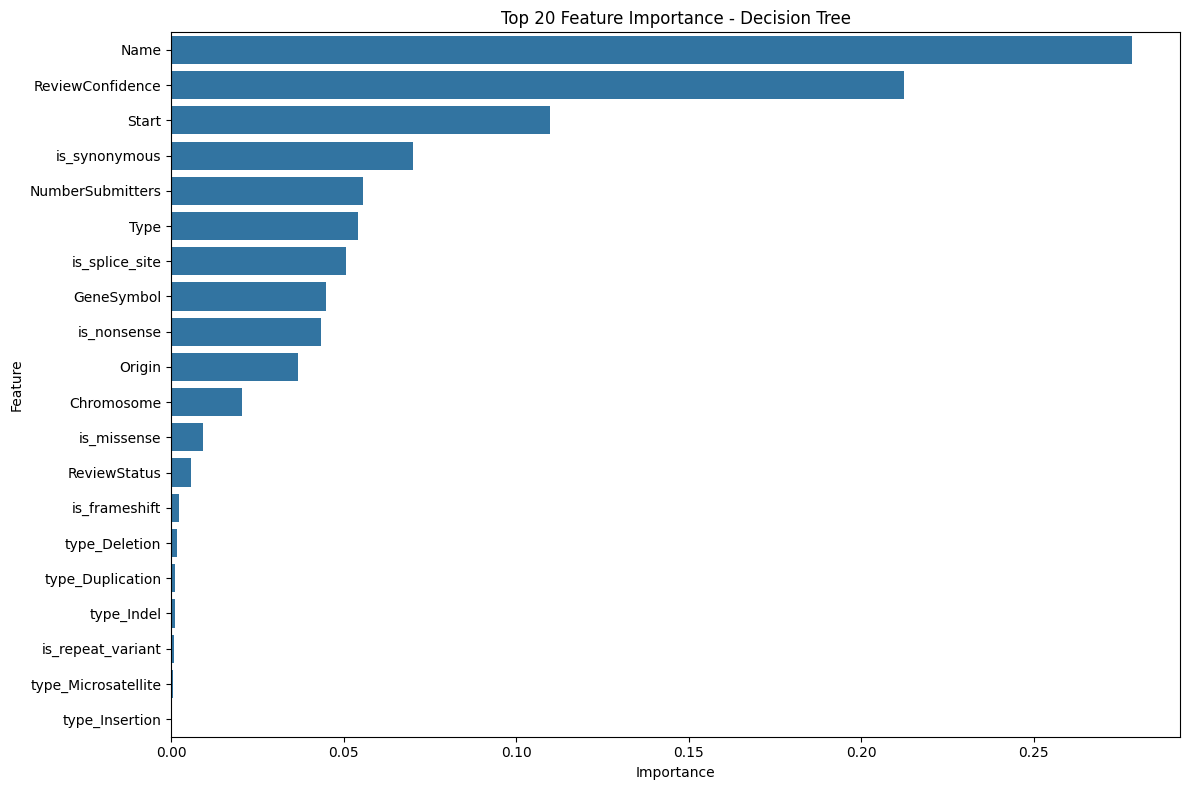

In [ ]:
# Plot feature importance
feature_importance = pd.DataFrame(
    {'Feature': X.columns, 'Importance': dt_model.feature_importances_}
)
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance - Decision Tree')
plt.tight_layout()
plt.savefig('decision_tree_feature_importance.png')
plt.show()


In [ ]:
# Summary of model performance
print("\nDecision Tree Model Performance Summary:")
print(f"Total samples: {len(y_test)}")
print(f"Training time: {training_time:.4f} seconds")
print(f"Inference time: {inference_time:.4f} seconds")
print(f"Inference time per sample: {inference_time/len(y_test):.8f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")


Decision Tree Model Performance Summary:
Total samples: 1256438
Training time: 77.4479 seconds
Inference time: 1.0853 seconds
Inference time per sample: 0.00000086 seconds
Accuracy: 0.8794
Precision (macro): 0.8338
Recall (macro): 0.8209
F1 Score (macro): 0.8271
